In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

            Precipitation
Date                     
2016-08-24           0.08
2016-08-24           2.15
2016-08-24           2.28
2016-08-24            NaN
2016-08-24           1.22
...                   ...
2017-08-22           0.50
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.45

[2223 rows x 1 columns]


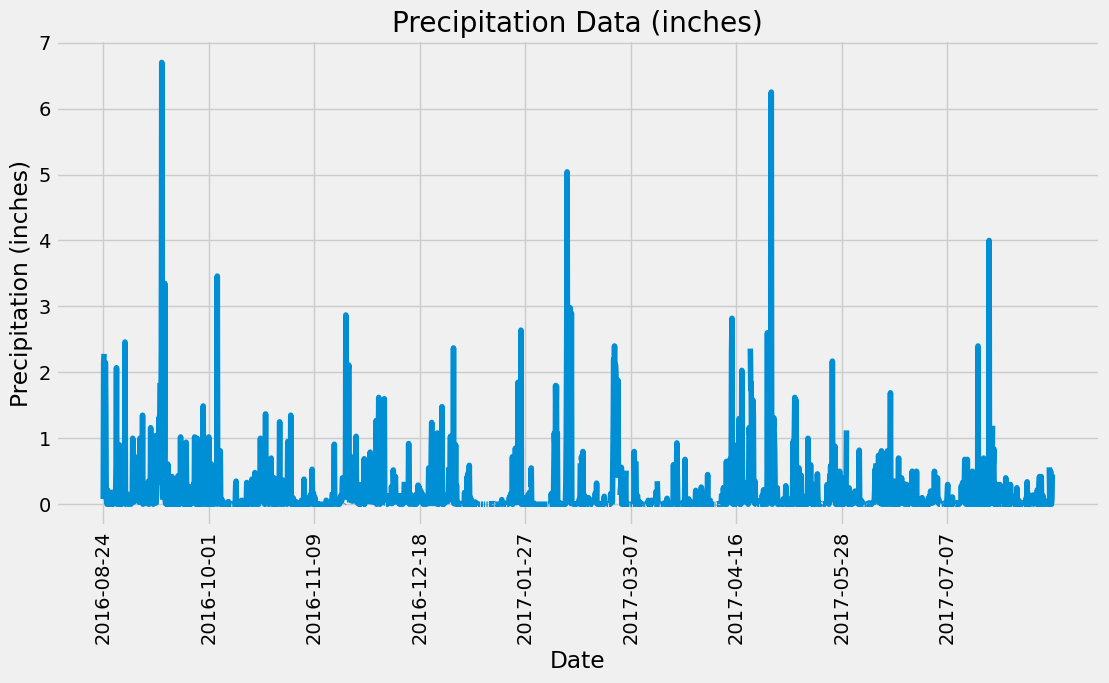

In [9]:
 #Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Star#ting from the most recent data point in the database. 

# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in data set.
recent_date = dt.datetime.strptime("2017-08-23", '%Y-%m-%d')
last_12_months = recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_12_months).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation.set_index('Date', inplace=True)
print(precipitation)

# Sort the dataframe by date
precipitation = precipitation.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation.plot(rot=90, figsize=(12,6), legend=False)
plt.title("Precipitation Data (inches)")
plt.ylabel("Precipitation (inches)")
plt.xlabel("Date")
plt.xticks(range(0, len(precipitation.index), len(precipitation.index)//9), precipitation.index[::len(precipitation.index)//9], rotation=90)
plt.show()


In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
print(total_stations)

9


In [12]:
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

most_active_station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).\
    all()
print(f'The lowest temperature for station {most_active_station_id} is ', most_active_station_stats[0][0])
print(f'The highest temperature for station {most_active_station_id} is ', most_active_station_stats[0][1])
print(f'The avg temperature for station {most_active_station_id} is ', most_active_station_stats[0][2])

The lowest temperature for station USC00519281 is  54.0
The highest temperature for station USC00519281 is  85.0
The avg temperature for station USC00519281 is  71.66378066378067


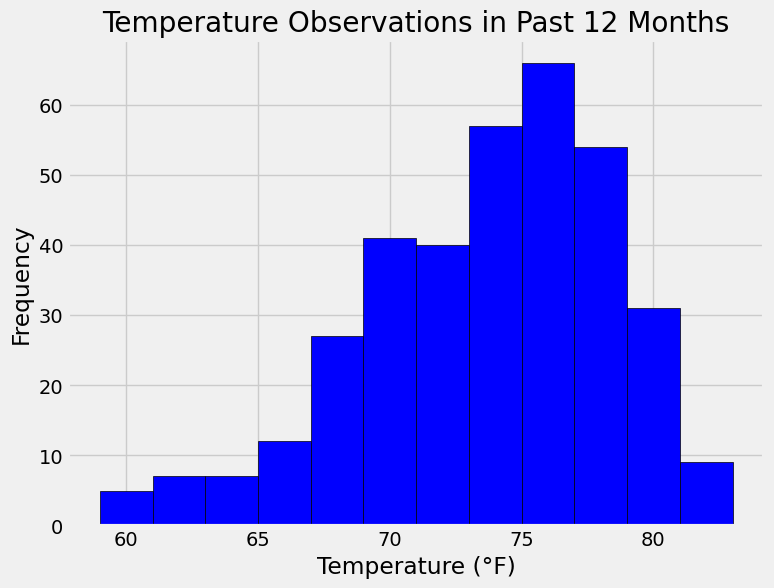

In [14]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Find the most recent date in the data set.

most_active_station_id = 'USC00519281'

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).\
    all()

recent_date = session.query(Measurement.date).\
filter(Measurement.station == most_active_station_id).\
order_by(Measurement.date.desc()).\
first()[0]

recent_date = dt.datetime.strptime("2017-08-18", '%Y-%m-%d')
last_12_months = recent_date - dt.timedelta(days=365)

last_12months_temps = session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.station == most_active_station_id).\
filter(Measurement.date >= last_12_months).\
all()

temperatures = [temp[1] for temp in last_12months_temps]

plt.figure(figsize=(8,6))
plt.hist(temperatures, bins=12, color='blue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations in Past 12 Months')
plt.grid(True)
plt.show()

# Close Session

In [15]:
# Close Session
session.close()